In [13]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
import matplotlib.ticker as ticker
import pandas as pd
import helmeos
from glob import glob
import subprocess
import os
from tqdm import tqdm
from joblib import Parallel, delayed
import joblib

In [14]:
gconst = 6.67430e-8
clight = 2.99792458e10
solar = 1.98847e33
vcgs2code = 1/clight
lencgs2code = (clight**2)/(solar*gconst)
masscgs2code = (1.0e0/solar)
rhocgs2code = (masscgs2code/lencgs2code**3)
tcgs2code = (clight**3)/(solar*gconst)
mu_0 = 1.25663706212e-6
amp2code = (mu_0*1.0e5*masscgs2code*lencgs2code)**(0.5e0)/tcgs2code
gauss2code = 1.0e-1*masscgs2code/amp2code/tcgs2code**2
energycgs2code = (1.0E0/clight**2)
me2 = 9.1093837015e-28*masscgs2code
mb2 = 1.66053906660e-24*masscgs2code
ye = 0.5e0
h_bar = (1.054571817e-27)*(lencgs2code**2*masscgs2code/tcgs2code)
amax = (me2**4)/(2.4e1*np.pi**2*h_bar**3)
bmax = (mb2*me2**3)/(3.0e0*np.pi**2*h_bar**3*ye)

def get_kappa_value(filepath):
    part_after_kappa = filepath.split('_kappa_')[-1]
    kappa_str = part_after_kappa.split('_alpha_')[0]
    return float(kappa_str)

def get_ratio_value(filepath):
    part_after_ratio = filepath.split('_AxisRatio_')[-1]
    ratio = part_after_ratio.split('_kappa_')[0]
    return float(ratio)

def ftc(arr):
    temp = (arr[1:,:] + arr[:-1,:])/2
    temp2 = (temp[:,1:]+temp[:,:-1])/2
    return temp2

def filtering(array,atmo_indicies):
    dummy = np.copy(array)
    dummy[atmo_indicies] = 0
    return dummy


In [15]:
data_paths = glob("/home/cnchong/Codes/cumc3d/model/Type_Ia/runs/Output_CentralDensity_*_AxisRatio_*/")
data_paths = sorted(data_paths, key=lambda filepath: float(filepath.split('_kappa_')[-1].split('_alpha_')[0]))
data_paths

['/home/cnchong/Codes/cumc3d/model/Type_Ia/runs/Output_CentralDensity_9.477_AxisRatio_1.000_kappa_0.000E+00_alpha_0.000E+00/',
 '/home/cnchong/Codes/cumc3d/model/Type_Ia/runs/Output_CentralDensity_9.477_AxisRatio_0.699_kappa_0.000E+00_alpha_0.000E+00/',
 '/home/cnchong/Codes/cumc3d/model/Type_Ia/runs/Output_CentralDensity_9.477_AxisRatio_0.699_kappa_0.100E-04_alpha_0.000E+00/',
 '/home/cnchong/Codes/cumc3d/model/Type_Ia/runs/Output_CentralDensity_9.477_AxisRatio_0.699_kappa_0.300E-04_alpha_0.000E+00/',
 '/home/cnchong/Codes/cumc3d/model/Type_Ia/runs/Output_CentralDensity_9.477_AxisRatio_0.699_kappa_0.500E-04_alpha_0.000E+00/',
 '/home/cnchong/Codes/cumc3d/model/Type_Ia/runs/Output_CentralDensity_9.477_AxisRatio_0.699_kappa_0.700E-04_alpha_0.000E+00/',
 '/home/cnchong/Codes/cumc3d/model/Type_Ia/runs/Output_CentralDensity_9.477_AxisRatio_0.699_kappa_0.100E-03_alpha_0.000E+00/']

In [16]:
initial_list = []
last_arr = []
time_arr = []
final_list = []
for data_path in tqdm(data_paths):

    working_directory = data_path+'outfile/'
    filename = working_directory+"/rkiter-"+str(0)+"-nm.hdf5"
    f = h5py.File(filename, "r")
    primitive = f['primitive'][:].T
    bfields = f['bfield'][:].T
    epsilon = f['epsilon'][:].T
    atmo = f['prim_a(irho)'][0]
    phi = f['phi'][:].T
    vol = (f['vol'][:].T)[:,0,:]

    rho = primitive[0,1:-1,1,1:-1]
    v1 = primitive[1,1:-1,1,1:-1]
    v2 = primitive[2,1:-1,1,1:-1]
    v3 = primitive[3,1:-1,1,1:-1]
    Xni = primitive[12,1:-1,1,1:-1]
    turb = primitive[5,1:-1,1,1:-1]

    br = ftc(bfields[0,1:-1,1,1:-1])
    bt = ftc(bfields[1,1:-1,1,1:-1])
    bz = ftc(bfields[2,1:-1,1,1:-1])

    vsq = v1**2+v2**2+v3**2
    B2 = (br**2+bt**2+bz**2)/gauss2code**2

    epsilon = epsilon[1:-1,1,1:-1]
    phi = phi[1:-1,1,1:-1]

    initial_mass = np.sum((vol*rho)[rho>atmo]) # in solar mass
    mass_Ni0 = np.sum((vol*rho*Xni)[rho>atmo]) # in solar mass
    KE0 = np.sum((vol*rho*vsq)[rho>atmo]/2)/(masscgs2code*energycgs2code) # in cgs
    B20 = np.sum((vol/lencgs2code**3*B2)/2) # in cgs
    IntE0 = np.sum((vol*rho*epsilon)[rho>atmo])/(masscgs2code*energycgs2code) # in cgs
    turbE0 = np.sum((vol*rho*turb)[rho>atmo])/(masscgs2code*energycgs2code) # in cgs
    GPE0 = np.sum((vol*rho*phi)[rho>atmo])/(masscgs2code*energycgs2code) # in cgs

    initial_list.append((initial_mass, mass_Ni0, KE0, B20, IntE0, turbE0, GPE0))

    f.close()

    #Finished initial stuff, now find last stuff.

    n = len(glob(working_directory+'/*.hdf5'))
    
    mass_list = []
    for i in range(n):
        filename = working_directory+"/rkiter-"+str(i)+"-nm.hdf5"
        f = h5py.File(filename, "r")
        primitive = f['primitive'][:].T
        atmo = f['prim_a(irho)'][0]
        rho = primitive[0,1:-1,1,1:-1]
        atmo_indicies = rho<=atmo
        filtered_rho = filtering(rho, atmo_indicies)
        mass_list.append(np.sum((filtered_rho*vol)))
        f.close()

    mass_arr = np.array(mass_list)
    
    try:
        last = np.argwhere((mass_arr-initial_mass) < -1e-5)[0][0]
    except:
        last = n-1
    last_arr.append(last)

    filename = working_directory+"/rkiter-"+str(last)+"-nm.hdf5"
    f = h5py.File(filename, "r")
    time_arr.append(f['time'][0]/tcgs2code)
    primitive = f['primitive'][:].T
    bfields = f['bfield'][:].T
    epsilon = f['epsilon'][:].T
    atmo = f['prim_a(irho)'][0]
    phi = f['phi'][:].T
    f.close()

    rho = primitive[0,1:-1,1,1:-1]
    v1 = primitive[1,1:-1,1,1:-1]
    v2 = primitive[2,1:-1,1,1:-1]
    v3 = primitive[3,1:-1,1,1:-1]
    Xni = primitive[12,1:-1,1,1:-1]
    turb = primitive[5,1:-1,1,1:-1]

    br = ftc(bfields[0,1:-1,1,1:-1])
    bt = ftc(bfields[1,1:-1,1,1:-1])
    bz = ftc(bfields[2,1:-1,1,1:-1])

    vsq = v1**2+v2**2+v3**2
    B2 = (br**2+bt**2+bz**2)/gauss2code**2

    epsilon = epsilon[1:-1,1,1:-1]
    phi = phi[1:-1,1,1:-1]

    mass = np.sum((vol*rho)[rho>atmo]) # in solar mass
    mass_Ni = np.sum((vol*rho*Xni)[rho>atmo]) # in solar mass
    KE = np.sum((vol*rho*vsq)[rho>atmo]/2)/(masscgs2code*energycgs2code) # in cgs
    B2 = np.sum((vol/lencgs2code**3*B2)/2) # in cgs
    IntE = np.sum((vol*rho*epsilon)[rho>atmo])/(masscgs2code*energycgs2code) # in cgs
    turbE = np.sum((vol*rho*turb)[rho>atmo])/(masscgs2code*energycgs2code) # in cgs
    GPE = np.sum((vol*rho*phi)[rho>atmo])/(masscgs2code*energycgs2code) # in cgs
    final_list.append((mass, mass_Ni, KE, B2, IntE, turbE, GPE))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [34:00<00:00, 291.47s/it]


/tmp/ipykernel_401156/2060432007.py:21: RuntimeWarning: invalid value encountered in log10
  ax[1,0].plot(kappa_list, np.log10(np.sum(np.array(initial_list)[:,2:], axis=1)), color='purple', linestyle='dashed', label='Total Energy')


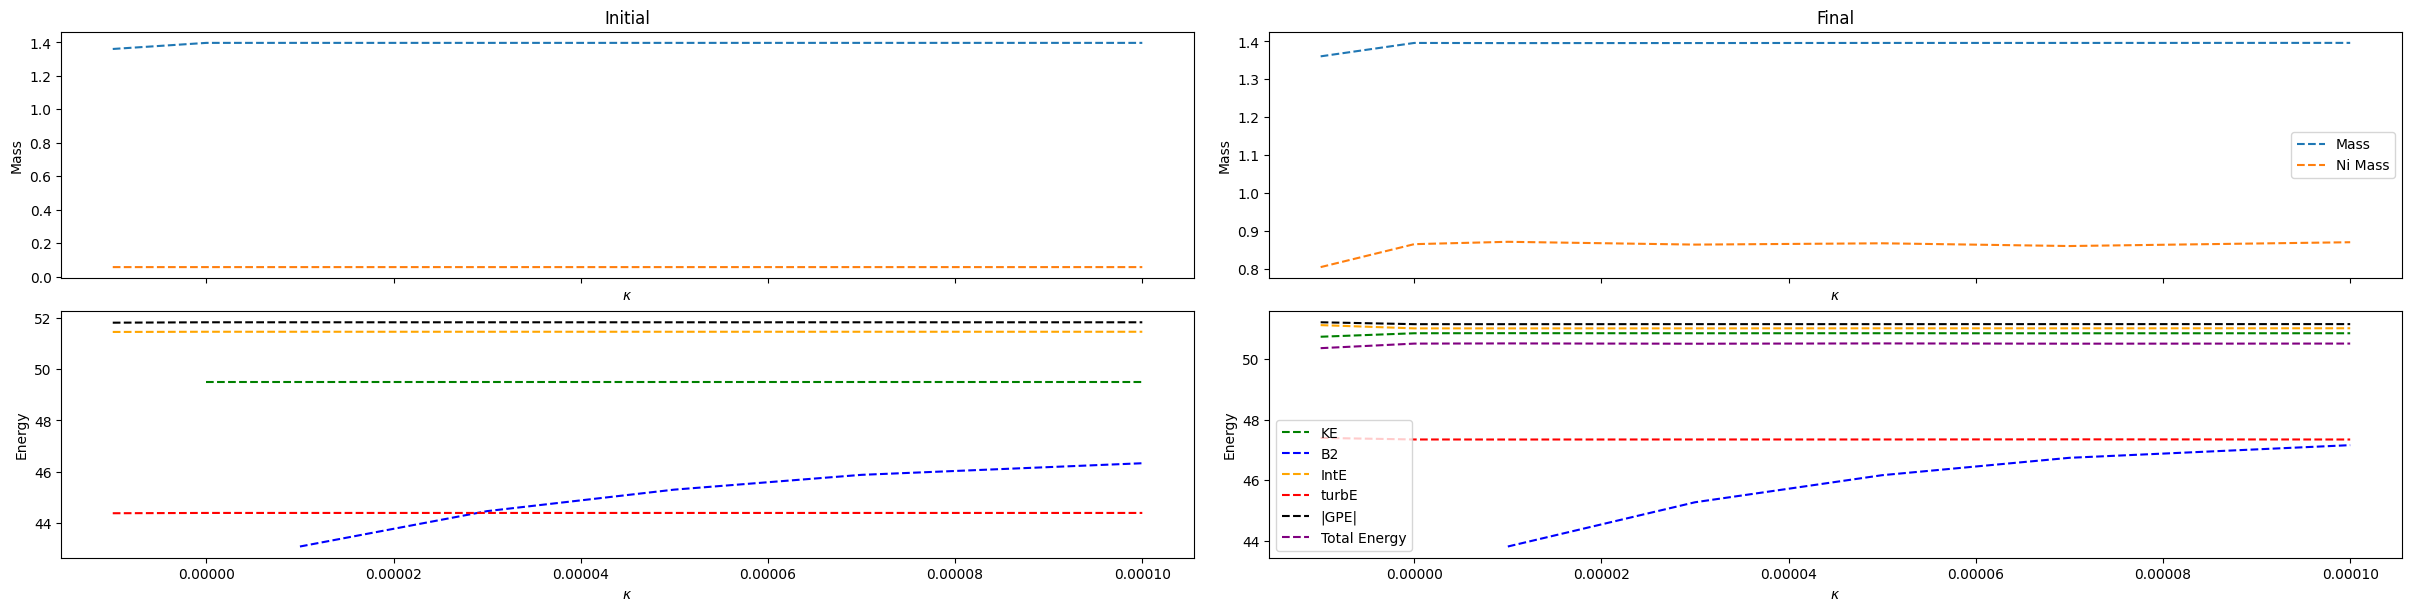

In [51]:
np.seterr(divide = 'ignore') 
fig, ax = plt.subplots(nrows=2, ncols=2, layout='constrained', figsize=(24,6), sharex={"col"})
kappa_list = []
label_list = ['KE', 'B2', 'IntE', 'turbE', '|GPE|']
color_list = ['green', 'blue', 'orange', 'red', 'black']
for j, chosen in enumerate(data_paths):
    kappa = get_kappa_value(chosen)
    kappa_list.append(kappa)
kappa_list[0] = -kappa_list[2]
ax[0,0].plot(kappa_list, np.array(initial_list)[:,0], linestyle='dashed', label='Mass')
ax[0,0].plot(kappa_list, np.array(initial_list)[:,1], linestyle='dashed', label='Ni Mass')
ax[0,0].set_ylabel('Mass')
ax[0,0].set_xlabel(r'$\kappa$')
ax[0,0].set_title(r'Initial')
for i in range(len(np.array(initial_list)[0,2:])):
    if label_list[i] == '|GPE|':
        ax[1,0].plot(kappa_list, np.log10(np.abs(np.array(initial_list)[:,i+2])), linestyle='dashed', color = color_list[i], label=label_list[i])
    else:
        ax[1,0].plot(kappa_list, np.log10(np.array(initial_list)[:,i+2]), linestyle='dashed', color = color_list[i], label=label_list[i])
    
ax[1,0].plot(kappa_list, np.log10(np.sum(np.array(initial_list)[:,2:], axis=1)), color='purple', linestyle='dashed', label='Total Energy')
ax[1,0].set_ylabel(r'Energy')
ax[1,0].set_xlabel(r'$\kappa$')


ax[0,1].plot(kappa_list, np.array(final_list)[:,0], linestyle='dashed', label='Mass')
ax[0,1].plot(kappa_list, np.array(final_list)[:,1], linestyle='dashed', label='Ni Mass')
ax[0,1].set_ylabel('Mass')
ax[0,1].set_xlabel(r'$\kappa$')
ax[0,1].set_title(r'Final')
ax[0,1].legend()
for i in range(len(np.array(final_list)[0,2:])):
    if label_list[i] == '|GPE|':
        ax[1,1].plot(kappa_list, np.log10(np.abs(np.array(final_list)[:,i+2])), linestyle='dashed', color = color_list[i], label=label_list[i])
    else:
        ax[1,1].plot(kappa_list, np.log10(np.array(final_list)[:,i+2]), linestyle='dashed', color = color_list[i], label=label_list[i])

ax[1,1].plot(kappa_list, np.log10(np.sum(np.array(final_list)[:,2:], axis=1)), linestyle='dashed', color = 'purple', label='Total Energy')
ax[1,1].set_ylabel(r'Energy')
ax[1,1].set_xlabel(r'$\kappa$')

plt.legend()
plt.savefig('kappa_plot')